In [1]:
# Gerekli Kütüphaneleri Yükleyin
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Input
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data= pd.read_csv(r"C:\Users\hsynt\Downloads\Selcuk Abi\Selcuk Abi\VeriSeti2.csv")

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8105 - loss: 0.4285 - val_accuracy: 0.8650 - val_loss: 0.3210
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8647 - loss: 0.3237 - val_accuracy: 0.8737 - val_loss: 0.3060
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8729 - loss: 0.3031 - val_accuracy: 0.8769 - val_loss: 0.2913
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8792 - loss: 0.2930 - val_accuracy: 0.8798 - val_loss: 0.2832
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8806 - loss: 0.2887 - val_accuracy: 0.8754 - val_loss: 0.2894
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8830 - loss: 0.2813 - val_accuracy: 0.8780 - val_loss: 0.2840
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8868 - loss: 0.2736 - val_accuracy: 0.8833 - val_loss: 0.2818
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8873 - loss: 0.2740 - 

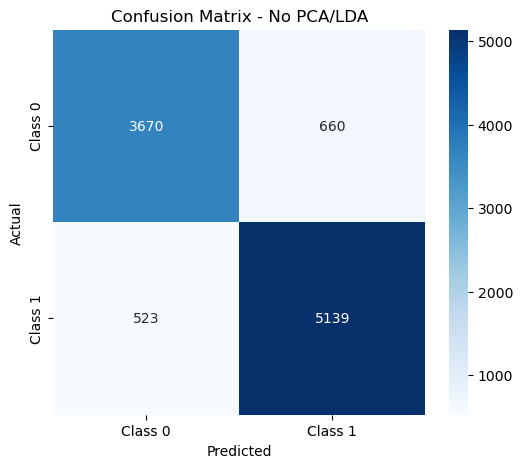

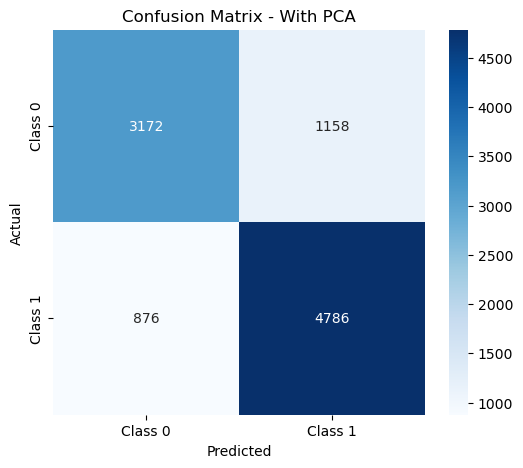

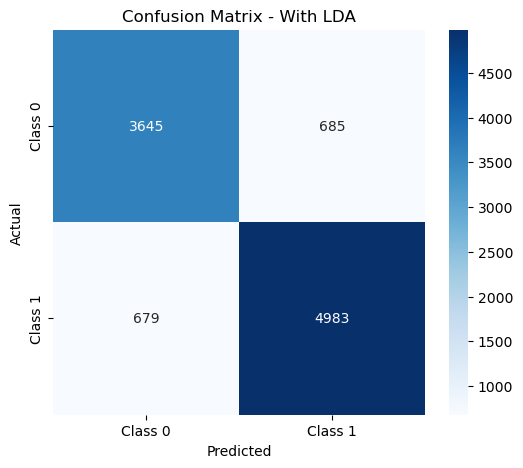

In [3]:
# Özellik ve Hedef Ayrımı
X = data.drop(columns=['Target_10', 'adjclose'])
y = data['Target_10']

# Zaman Serisi Formatına Getirme (CNN-LSTM için 3D input)
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Sekans boyutu
SEQ_LENGTH = 10

# Özellikleri Ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sekans Verisi Oluşturma
X_seq = create_sequences(X_scaled, SEQ_LENGTH)
y_seq = y[SEQ_LENGTH:].values

# Eğitim ve Test Setlerine Bölme
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# CNN-LSTM Modelini Tanımlama
def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=1, activation='relu'),
        MaxPooling1D(pool_size=1),
        LSTM(64, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Performans Metriklerini Hesaplama
def calculate_metrics(y_true, y_pred, y_pred_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_pred_proba)
    }

# Holdout Sonuçları
cnn_lstm_model = build_cnn_lstm_model(X_train.shape[1:])
cnn_lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Tahminler
y_pred_no_reduction = (cnn_lstm_model.predict(X_test) > 0.5).astype("int32").flatten()
y_pred_proba_no_reduction = cnn_lstm_model.predict(X_test).flatten()

# Holdout Metrikleri
holdout_results = {
    "No PCA/LDA": calculate_metrics(y_test, y_pred_no_reduction, y_pred_proba_no_reduction)
}

# PCA ve LDA için Ekstra İşlem
pca = PCA(n_components=10)
lda = LDA()

X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

X_train_lda = lda.fit_transform(X_train.reshape(X_train.shape[0], -1), y_train)
X_test_lda = lda.transform(X_test.reshape(X_test.shape[0], -1))

# PCA ve LDA Sonrası Verileri 3D Hale Getirme
X_train_pca = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_pca = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))

X_train_lda = X_train_lda.reshape((X_train_lda.shape[0], X_train_lda.shape[1], 1))
X_test_lda = X_test_lda.reshape((X_test_lda.shape[0], X_test_lda.shape[1], 1))

# PCA ile CNN-LSTM Modeli
cnn_lstm_model_pca = build_cnn_lstm_model(X_train_pca.shape[1:])
cnn_lstm_model_pca.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred_pca = (cnn_lstm_model_pca.predict(X_test_pca) > 0.5).astype("int32").flatten()
y_pred_proba_pca = cnn_lstm_model_pca.predict(X_test_pca).flatten()

holdout_results["With PCA"] = calculate_metrics(y_test, y_pred_pca, y_pred_proba_pca)

# LDA ile CNN-LSTM Modeli
cnn_lstm_model_lda = build_cnn_lstm_model(X_train_lda.shape[1:])
cnn_lstm_model_lda.fit(X_train_lda, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred_lda = (cnn_lstm_model_lda.predict(X_test_lda) > 0.5).astype("int32").flatten()
y_pred_proba_lda = cnn_lstm_model_lda.predict(X_test_lda).flatten()

holdout_results["With LDA"] = calculate_metrics(y_test, y_pred_lda, y_pred_proba_lda)

# Holdout Sonuçlarını Gösterme
holdout_df = pd.DataFrame(holdout_results).T
print("Holdout Results:")
print(holdout_df)

# K-Fold Çapraz Doğrulama
kf = KFold(n_splits=3)
kfold_results = []

# K-Fold için PCA ve LDA ile Ayrı Ayrı İşlem Yapma
for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    for reduction, (X_tr, X_te) in zip(
        ["No PCA/LDA", "With PCA", "With LDA"],
        [(X_train, X_test), (X_train_pca, X_test_pca), (X_train_lda, X_test_lda)]
    ):
        X_fold_train, X_fold_test = X_tr[train_index], X_tr[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        cnn_lstm_model_fold = build_cnn_lstm_model(X_fold_train.shape[1:])
        cnn_lstm_model_fold.fit(X_fold_train, y_fold_train, epochs=5, batch_size=32)

        y_fold_pred = (cnn_lstm_model_fold.predict(X_fold_test) > 0.5).astype("int32").flatten()
        y_fold_proba = cnn_lstm_model_fold.predict(X_fold_test).flatten()

        metrics = calculate_metrics(y_fold_test, y_fold_pred, y_fold_proba)
        metrics['Model'] = 'CNN-LSTM'
        metrics['Reduction'] = f'{reduction} (Fold {fold + 1})'
        kfold_results.append(metrics)

# K-Fold Sonuçlarını Gösterme
kfold_df = pd.DataFrame(kfold_results)
print("\nK-Fold Results:")
print(kfold_df)

# Karışıklık Matrislerini Görselleştirme
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, y_pred_no_reduction, "Confusion Matrix - No PCA/LDA")
plot_confusion_matrix(y_test, y_pred_pca, "Confusion Matrix - With PCA")
plot_confusion_matrix(y_test, y_pred_lda, "Confusion Matrix - With LDA")